
## Predicting the likely duration of a taxi trip using SGD Regressor over a very large dataset.
### Dataset used: N. Y. CityCabs data (1 billion samples)

In [1]:
import vaex
import vaex.ml

import numpy as np

import pylab as plt

import warnings
warnings.filterwarnings("ignore")

### Adjusting `matplotlib` parameters

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Reading in the data

Reading data stored on S3. The data is streamed on a need-to-have basis and is locally cached.

In [3]:
df = vaex.open('s3://vaex/taxi/yellow_taxi_2009_2015_f32.hdf5?anon=true')

Opening a DataFrame straight from S3 will lazily download the data. 

In [4]:
# Inspecting the data
df

#              vendor_id    pickup_datetime                dropoff_datetime               passenger_count    payment_type    trip_distance    pickup_longitude    pickup_latitude    rate_code    store_and_fwd_flag    dropoff_longitude    dropoff_latitude    fare_amount    surcharge    mta_tax    tip_amount    tolls_amount    total_amount
0              VTS          2009-01-04 02:52:00.000000000  2009-01-04 03:02:00.000000000  1                  CASH            2.63             -73.99196           40.721565          nan          nan                   -73.993805           40.695923           8.9            0.5          nan        0.0           0.0             9.4
1              VTS          2009-01-04 03:31:00.000000000  2009-01-04 03:38:00.000000000  3                  Credit          4.55             -73.9821            40.73629           nan          nan                   -73.95585            40.76803            12.1           0.5          nan        2.0           0.0             14.6
2              VTS          2009-01-03 15:43:00.000000000  2009-01-03 15:57:00.000000000  5                  Credit          10.35            -74.00259           40.739746          nan          nan                   -73.86998            40.770226           23.7           0.0          nan        4.74          0.0             28.44
3              DDS          2009-01-01 20:52:58.000000000  2009-01-01 21:14:00.000000000  1                  CREDIT          5.0              -73.974266          40.790955          nan          nan                   -73.99656            40.73185            14.9           0.5          nan        3.05          0.0             18.45
4              DDS          2009-01-24 16:18:23.000000000  2009-01-24 16:24:56.000000000  1                  CASH            0.4              -74.00158           40.719383          nan          nan                   -74.00838            40.72035            3.7            0.0          nan        0.0           0.0             3.7
...            ...          ...                            ...                            ...                ...             ...              ...                 ...                ...          ...                   ...                  ...                 ...            ...          ...        ...           ...             ...
1,173,057,922  VTS          2015-12-31 23:59:56.000000000  2016-01-01 00:08:18.000000000  5                  1               1.2              -73.99381           40.72087           1.0          0.0                   -73.98621            40.72247            7.5            0.5          0.5        1.76          0.0             10.56
1,173,057,923  CMT          2015-12-31 23:59:58.000000000  2016-01-01 00:05:19.000000000  2                  2               2.0              -73.96527           40.76028           1.0          0.0                   -73.939514           40.752388           7.5            0.5          0.5        0.0           0.0             8.8
1,173,057,924  CMT          2015-12-31 23:59:59.000000000  2016-01-01 00:12:55.000000000  2                  2               3.8              -73.9873            40.73908           1.0          0.0                   -73.98867            40.6933             13.5           0.5          0.5        0.0           0.0             14.8
1,173,057,925  VTS          2015-12-31 23:59:59.000000000  2016-01-01 00:10:26.000000000  1                  2               1.96             -73.99756           40.725693          1.0          0.0                   -74.01712            40.705322           8.5            0.5          0.5        0.0           0.0             9.8
1,173,057,926  VTS          2015-12-31 23:59:59.000000000  2016-01-01 00:21:30.000000000  1                  1               1.06             -73.9844            40.767258          1.0          0.0                   -73.99098            40.76057            13.5           0.5          0.5        2.96          0.0             17.76

### Splitting the data into train & test sets

- All data prior to 2015 is train;
- All data of 2015 is test.

In [5]:
# Train / test split (by date, data is ordered by year)
df_train = df[:1_026_944_937]
df_test = df[1_026_944_937:]
df_test_prod = df_test.copy() # For an in-production scenario example

print(f'Number of samples in the training set: {len(df_train):,}')
print(f'Number of samples in the test set:       {len(df_test):,}')

# Checking if the lengths of the datasets match
assert len(df) == len(df_test) + len(df_train)

Number of samples in the training set: 1,026,944,937
Number of samples in the test set:       146,112,990


### Initial feature generation
 - creating tha target variable: "trip_duration_min" (duration of the taxi trips in minutes)
 - the mean speed of the trip: "trip_speed_mph" (in miles per hour, useful for cleaning spurious samples)

In [6]:
# Time in transit (minutes) - This is the target variable
df_train['trip_duration_min'] = (df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                   np.timedelta64(1, 'm')

In [7]:
# Speed (miles per hour) - To be used for cleaning of the training data
df_train['trip_speed_mph'] = df_train.trip_distance / \
                                ((df_train.dropoff_datetime - df_train.pickup_datetime) / \
                                np.timedelta64(1, 'h'))

### Data cleaning



In [8]:
# Filtering abnormal number of passengers
df_train = df_train[(df_train.passenger_count>0) & (df_train.passenger_count<7)]

# Selecting taxi trips have travelled maximum 7 miles (but also with non-zero distance).
df_train = df_train[(df_train.trip_distance > 0) & (df_train.trip_distance < 7)]

# Filtering taxi trips that have durations longer than 25 minutes or that lasted less than 3 minutes
df_train = df_train[(df_train.trip_duration_min > 3) & (df_train.trip_duration_min < 25)]

# Filtering out errouneous average trip speeds.
df_train = df_train[(df_train.trip_speed_mph > 1) & (df_train.trip_speed_mph < 60)]

# Defining the NYC boundaries
long_min = -74.05
long_max = -73.75
lat_min = 40.58
lat_max = 40.90

# Making a selection based on the boundaries
df_train = df_train[(df_train.pickup_longitude > long_min)  & (df_train.pickup_longitude < long_max) & \
                    (df_train.pickup_latitude > lat_min)    & (df_train.pickup_latitude < lat_max) & \
                    (df_train.dropoff_longitude > long_min) & (df_train.dropoff_longitude < long_max) & \
                    (df_train.dropoff_latitude > lat_min)   & (df_train.dropoff_latitude < lat_max)]


df_train['dropoff_latitude'] = df_train.dropoff_latitude.fillna(value=40.76)
df_train['pickup_latitude'] = df_train.pickup_latitude.fillna(value=40.76)

df_train['dropoff_longitude'] = df_train.dropoff_longitude.fillna(value=-73.99)
df_train['pickup_longitude'] = df_train.pickup_longitude.fillna(value=-73.99)

### Create some additional features:
 - feature: the pickup time
 - feature: the pickup day
 - feature: the pickup month
 - feature: is the pickup on a weekend
 - feature: "as the crow" files distance between the pickup and the dropoff location
 - feature: the direction angle from the pickup to the dropoff location

In [9]:
# Pickup datetime features
df_train['pickup_time'] = df_train.pickup_datetime.dt.hour + df_train.pickup_datetime.dt.minute / 60.
df_train['pickup_day'] = df_train.pickup_datetime.dt.dayofweek
df_train['pickup_month'] = df_train.pickup_datetime.dt.month - 1 # so it starts from 0
df_train['pickup_is_weekend'] = (df_train.pickup_day>=5).astype('int')

In [10]:
# Arc distance  in miles
def arc_distance(theta_1, phi_1, theta_2, phi_2):
    temp = (np.sin((theta_2-theta_1)/2*np.pi/180)**2
           + np.cos(theta_1*np.pi/180)*np.cos(theta_2*np.pi/180) * np.sin((phi_2-phi_1)/2*np.pi/180)**2)
    distance = 2 * np.arctan2(np.sqrt(temp), np.sqrt(1-temp))
    return distance * 3958.8

# Creating the feature
df_train['arc_distance'] = arc_distance(df_train.pickup_longitude, 
                                        df_train.pickup_latitude, 
                                        df_train.dropoff_longitude, 
                                        df_train.dropoff_latitude).jit_numba()

In [11]:
# Direction of travel in degrees
def direction_angle(theta_1, phi_1, theta_2, phi_2):
    dtheta = theta_2 - theta_1
    dphi = phi_2 - phi_1
    radians = np.arctan2(dtheta, dphi)
    return np.rad2deg(radians)

# Creating the feature
df_train['direction_angle'] = direction_angle(df_train.pickup_longitude, 
                                              df_train.pickup_latitude, 
                                              df_train.dropoff_longitude, 
                                              df_train.dropoff_latitude).jit_numba()

Review the newly created features, and at the same time evaluate created filters.

In [12]:
# Getting a preview of the training data
df_train

### Transforming features: PCA of the pick-up and drop-off locations

In [ ]:
# PCA of the pickup and dropoff locations, to straighten out the coordinates

# pickup transformations
pca_pickup = vaex.ml.PCA(features=['pickup_longitude', 'pickup_latitude'], n_components=2, prefix='PCA_pickup_')
df_train = pca_pickup.fit_transform(df_train)

# dropoff transformations
pca_dropoff = vaex.ml.PCA(features=['dropoff_longitude', 'dropoff_latitude'], n_components=2, prefix='PCA_dropoff_')
df_train = pca_dropoff.fit_transform(df_train)

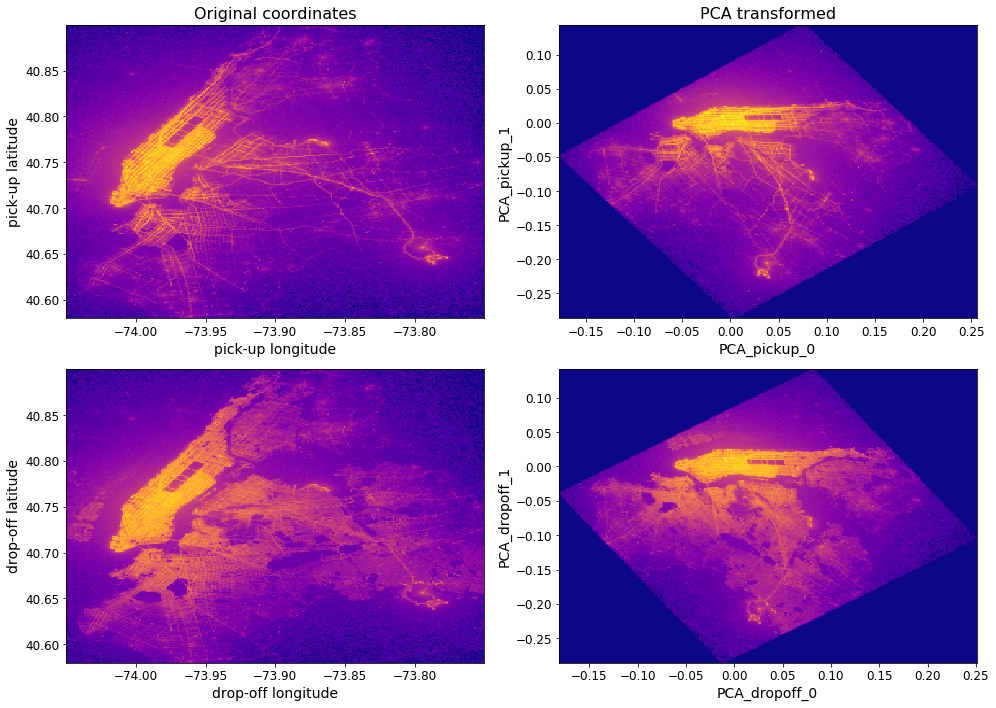

In [ ]:
# Visualising the PCA results to make sure they makes sense
plt.figure(figsize=(14, 10))

plt.subplot(221)
plt.title('Original coordinates', fontsize=16)
df_train.plot(df_train.pickup_longitude, df_train.pickup_latitude,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False, 
              xlabel='pick-up longitude', ylabel='pick-up latitude')

plt.subplot(222)
plt.title('PCA transformed', fontsize=16)
df_train.plot(df_train.PCA_pickup_0, df_train.PCA_pickup_1,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False,
              xlabel='PCA_pickup_0', ylabel='PCA_pickup_1')
              

plt.subplot(223)
df_train.plot(df_train.dropoff_longitude, df_train.dropoff_latitude,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False,
              xlabel='drop-off longitude', ylabel='drop-off latitude')

plt.subplot(224)
df_train.plot(df_train.PCA_dropoff_0, df_train.PCA_dropoff_1,
              limits='minmax', f='log1p', shape=256,
              colormap='plasma', colorbar=False,
              xlabel='PCA_dropoff_0', ylabel='PCA_dropoff_1')

plt.tight_layout()
plt.show()

### Handling temporal (cyclical) features
 - Assuming the temporal feature is the $\theta$ coordinate of a unit circle in polar coordinates. Converting it to Cartesian $(x, y)$ coordinates. This preserves the continuity (12 o'clock is close to 1 o'clock).

In [ ]:
# Time
cycl_transform_time = vaex.ml.CycleTransformer(features=['pickup_time'], n=24)
df_train = cycl_transform_time.fit_transform(df_train)

# Day
cycl_transform_day = vaex.ml.CycleTransformer(features=['pickup_day'], n=7)
df_train = cycl_transform_day.fit_transform(df_train)

# Month
cycl_transform_month = vaex.ml.CycleTransformer(features=['pickup_month'], n=12)
df_train = cycl_transform_month.fit_transform(df_train)

# Direction angle
cycl_transform_angle = vaex.ml.CycleTransformer(features=['direction_angle'], n=360)
df_train = cycl_transform_angle.fit_transform(df_train)

To make sure that the above transformations make sense, let's plot the transformed coordinates for the pickup_time feature.

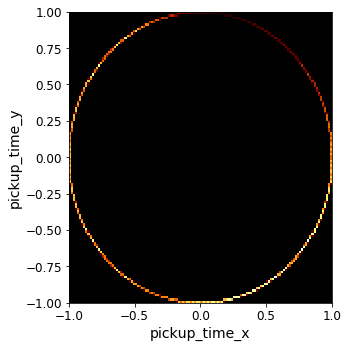

In [ ]:
# Examining the transformed data
df_train.plot(x='pickup_time_x', y='pickup_time_y', 
              shape=128, limits=[-1, 1],
              figsize=(5, 5),
              colorbar=False)
plt.show()

Note that unlike a regular wall clock, all 24 hours are represented on the circle below. So in this case:
    - "midnight" has coordinates (x, y) = (1, 0)
    - "6 o'clock" has coordinates (x, y) = (0, 1)

### Scaling of numerical features

In [ ]:
# Standard scaling of numerical features
standard_scaler = vaex.ml.StandardScaler(features=['arc_distance'])
df_train = standard_scaler.fit_transform(df_train)

### Preview the training features

In [ ]:
# Selecting all the features to be used for training the model
features = df_train.get_column_names(regex='PCA*') + \
           df_train.get_column_names(regex='standard_scaled_*') + \
           df_train.get_column_names(regex='.*_x') + \
           df_train.get_column_names(regex='.*_y') + \
           ['pickup_is_weekend']

# Previewing the features
df_train.head(10)[features]

#    PCA_pickup_0    PCA_pickup_1    PCA_dropoff_0    PCA_dropoff_1    standard_scaled_arc_distance    pickup_time_x    pickup_day_x    pickup_month_x    direction_angle_x    pickup_time_y    pickup_day_y    pickup_month_y    direction_angle_y    pickup_is_weekend
  0     -0.0309687      -0.00923445      -0.0549368      -0.0194697                         -0.723864        0.731354         0.62349                  1           -0.997418          0.681998       -0.781831                 0            -0.071816                    1
  1     -0.0132836      -0.00813007       0.0260018      -0.0100453                          0.846021        0.605294         0.62349                  1            0.770554          0.796002       -0.781831                 0             0.637374                    1
  2      0.0349145       0.0188245       -0.0268506       0.00310216                         0.841615        0.681998        -0.900969                 1           -0.935657         -0.731354        0.433884                 0            -0.35291                     0
  3     -0.0385425      -0.00291336      -0.0430175       0.00635435                        -0.762796       -0.430511        -0.222521                 1            0.140566         -0.902585       -0.974928                 0            -0.990071                    1
  4     -0.0189826      -0.00278667      -0.0264009      -0.0105712                         -0.856012        0.932008        -0.900969                 1           -0.910151         -0.362438       -0.433884                 0             0.414276                    0
  5     -0.00869855     -0.00217986      -0.00355497     -0.000696072                       -0.973832       -0.691513        -0.222521                 1            0.817867          0.722364        0.974928                 0             0.575407                    0
  6     -0.0100842       0.00757169      -0.0292228       0.000294064                       -0.804197        0.378649         0.62349                  1           -0.989393          0.925541       -0.781831                 0            -0.145266                    1
  7      0.0045462      -0.0101312       -0.00750687      0.008896                           0.310404       -0.386711         1                        1            0.0883862        -0.922201        0                        0            -0.996086                    0
  8      0.0402186      -0.00115382       0.0300554      -0.00394045                        -0.970312        0.2292           1                        1           -0.923064         -0.973379        0                        0            -0.384646                    0
  9     -0.0182035       0.0183147        0.00866121      0.00545972                         0.865825       -0.0915016        1                        1            0.452811          0.995805        0                        0             0.891607                    0

### Set the target variable

In [ ]:
# The target variable
target = 'trip_duration_min'

### Train a machine learning model

The strategy here is simple. One can use an online learner such as `sklearn.linear_model.SGDRegressor`. Vaex will be used to filter/pre-process the entire data, and will send batches of it to the model. The size of the batches does not impact the model performance in the case of on-line learners, since they process one sample at the time anyway. It can impact the speed with which the model is trained however, and it can be used to controll the RAM used.

The `vaex.ml.sklearn.IncrementalPredictor` nicely wraps any `scikit-learn` model which contains the `.partial_fit` method, and behaves as any other `vaex` transformer.

In [ ]:
from sklearn.linear_model import SGDRegressor
from vaex.ml.sklearn import IncrementalPredictor

# Defining the base model
model = SGDRegressor(learning_rate='constant', eta0=0.0001)

# The Vaex incremental model wrapper
vaex_model = IncrementalPredictor(features=features,
                                  target=target,
                                  model=model,
                                  batch_size=11_000_000, 
                                  num_epochs=1, 
                                  shuffle=False, 
                                  prediction_name='predicted_duration_min')

# Fitting the model
vaex_model.fit(df=df_train, progress='widget')

Once the model is trained, we can simply add the predictions as a _virtual column_ in the training set. Not only will this not take any memory, but will make it very easy for us to calculate various performance metrics, and construct diagnostic plots.

In [ ]:
df_train = vaex_model.transform(df_train)
# Examining a portion of the predictions
df_train.head(5)['trip_duration_min', 'predicted_duration_min']

#    trip_duration_min    predicted_duration_min
  0              10                        7.26828
  1               7                       10.6106
  2              21.0333                  14.715
  3               6.55                    11.2139
  4               7.6                      8.59366

Due to the nature of the model we chose for this exercies, it is possible that an exotic combination of feature values can make predicted duration negative. This is of course no possible. We are also training the model on taxi trips that took between 3 and 25 minutes, so let's force the model to not extrapolate but keep to those bounds:
 - set the predicted duration value to 3 min whenever the model outputs value smaller than 3; 
 - set the predicted duration value to 25 min whenever the model outputs value larger than 25. 

In [ ]:
# Values lower than 3 minutes are set to 3; values higher than 25 minutes are set to 25
df_train['pred_final'] = df_train.predicted_duration_min.clip(3, 25)

### State transfer (a.k.a the `vaex` automatic pipeline)

Now that the model is trained, we would like to apply it to full unseen validation or test data. Unlike many other libraries, no pipeline was _explicitly_ created to house all the cleaning, feature engineering, pre-processing and modelling steps. However, `vaex` keep track of all the changes that are done on a DataFrame. All the column transformations are kept in something that is called a "state".  The state which contains all the filtering or cleaning done on a DataFrame, as well as all virtual columns that were created or modified (e.g. newly engineered features, transformed features for instance scaled numerical or categorical encoded features, model predictions).
mns, and even the model prediction! 

Thus all that is needed is to extract the state object from the training DataFrame and apply it to the test DataFrame, and all the transformations will be automatically applied! Just as if a pipeline was created. 

In [ ]:
# Getting the state from the training DataFrame
state = df_train.state_get()
# Setting it on the test set
df_test.state_set(state)
# Previewing the test set
df_test.head(5)[features + ['predicted_duration_min', 'pred_final']]

#    PCA_pickup_0    PCA_pickup_1    PCA_dropoff_0    PCA_dropoff_1    standard_scaled_arc_distance    pickup_time_x    pickup_day_x    pickup_month_x    direction_angle_x    pickup_time_y    pickup_day_y    pickup_month_y    direction_angle_y    pickup_is_weekend    predicted_duration_min    pred_final
  0     -0.00945992     0.0096326        0.000937619      -0.00425876                        0.185894         0.279829       -0.900969                 1            0.0265375        -0.96005         0.433884                 0             0.999648                    0                  12.8878       12.8878
  1     -0.034722       9.11821e-05     -0.00314787        0.0167357                        -0.360025         0.619094       -0.222521                 1            0.979155         -0.785317       -0.974928                 0             0.203116                    1                  10.2087       10.2087
  2      0.05095        0.0173249        0.0747998         0.0184898                        -0.286859         0.619094       -0.222521                 1            0.882577         -0.785317       -0.974928                 0             0.470168                    1                   8.6574        8.6574
  3      0.0141202     -0.000946495     -0.0222436         0.0154948                         1.29113          0.619094       -0.222521                 1           -0.513971         -0.785317       -0.974928                 0            -0.857808                    1                  15.677        15.677
  4     -0.0221668     -0.0134367       -0.0098668         0.00977656                       -0.418611         0.619094       -0.222521                 1            0.931923         -0.785317       -0.974928                 0            -0.362657                    1                   9.90662       9.90662

### Model diagnostics

Checking some metrics: 
mean absolute error and mean squared error. 
Since the predictions are virtual columns, we can easily compute diagnostics regardless of how much data we have. It costs no memory!

In [ ]:
train_mae = df_train.mean(np.abs(df_train.pred_final - df_train.trip_duration_min))
train_mse = df_train.mean((df_train.pred_final - df_train.trip_duration_min)**2.)

test_mae = df_test.mean(np.abs(df_test.pred_final - df_test.trip_duration_min))
test_mse = df_test.mean((df_test.pred_final - df_test.trip_duration_min)**2.)

print(f'The train mean absolute error is {train_mae:.3} minuts.')
print(f'The train mean squared error is {train_mse:.3} minutes squared.')
print('')
print(f'The test mean absolute error is {test_mae:.3} minuts.')
print(f'The test mean squared error is {test_mse:.3} minutes squared.')

The train mean absolute error is 3.46 minuts.
The train mean squared error is 18.6 minutes squared.

The test mean absolute error is 3.54 minuts.
The test mean squared error is 19.9 minutes squared.


Create some diagnostic plots:
 - See the distribution of actual vs predicted trip duration times
 - The absolute error of the predicted durations

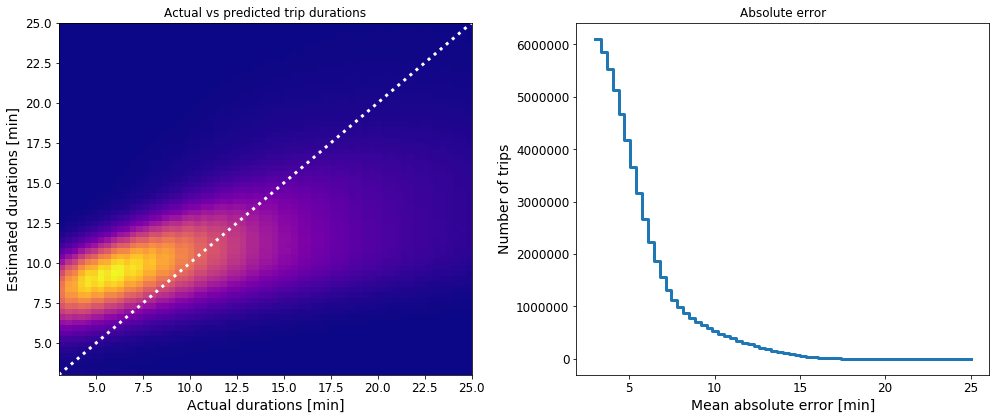

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
df_test.plot(x='trip_duration_min', y='pred_final', shape=64, limits=[3, 25], colorbar=False, colormap='plasma')
plt.plot([3, 25], [3, 25], color='w', lw=3, ls=':')

plt.title('Actual vs predicted trip durations')
plt.xlabel('Actual durations [min]')
plt.ylabel('Estimated durations [min]')

plt.subplot(122)
df_test['abs_error'] = np.abs(df_test.trip_duration_min - df_test.pred_final)
df_test.plot1d('abs_error', shape=64, lw=3, limits=[3, 25], color='C0')

plt.title('Absolute error')
plt.xlabel('Mean absolute error [min]')
plt.ylabel('Number of trips')

plt.tight_layout()
plt.show()

In [ ]:
# Seeing what percentage of the trips durations are predicted with an absolute error less than 5 minutes.
num_abs_err_under_5_min = df_test.count('abs_error', selection='abs_error < 5')
num_trips = len(df_test)
err_perc = num_abs_err_under_5_min / num_trips * 100

print(f'{err_perc:.3}% of the trips durations in the test set were predicted within an absolute error of 5 minutes.')

76.5% of the trips durations in the test set were predicted within an absolute error of 5 minutes.


From the above metrics and diagnostic plots, it looks like there is a lot of room for improvement!

See which features are more valued by the model.

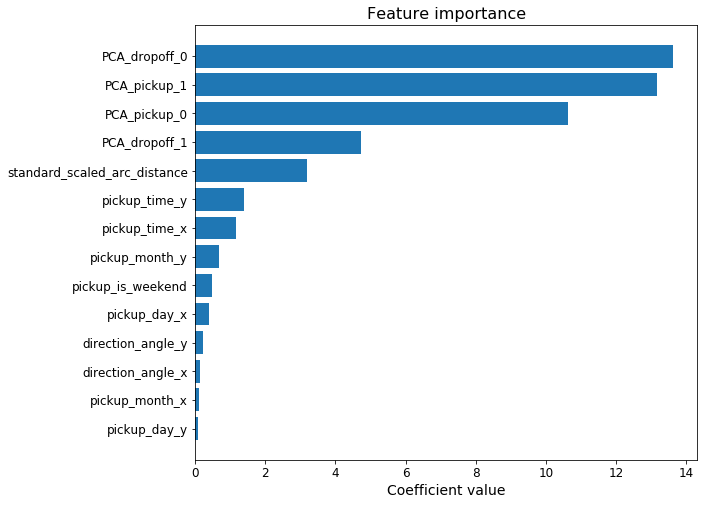

In [ ]:
# Feature importance

# Sorting indices of the features by their importance 
ind = np.argsort(np.abs(vaex_model.model.coef_))
# Sorting the coefficients 
coef_ = np.abs(model.coef_[ind])
# Sorting the features
features_ = np.array(features)[ind]

# Plotting the feature importance
n_features = len(coef_)

plt.figure(figsize=(9, 8))
plt.barh(y=range(n_features), width=coef_)
plt.yticks(ticks=range(n_features), labels=features_)
plt.title('Feature importance', fontsize=16)
plt.xlabel('Coefficient value')
plt.show()